## How to Load different Object Detectors

This notebook provides a beginner friendly introduction to loading object detectors as part of Test & Evaluation of a the VisDrone dataset. For illustration purposes, we first load the list if supported models and then load a subset of these models and plot their output on two images. Being able to exchange the model tested is crucial within T&E. 

❗**Make sure the model you chose is suitable for the data you want to use**❗

__Intended Audience__: All T&E users 

__Requirements__: Basic Python and Torchvision / ML skills

__Time Required__: Full run of the notebook: <1 minute

__Order of completion__: 1.-2., then arbitrary order

### Contents
1. Imports and set-up
2. Get list of supported models
3. Load data and model
4. Loading a second, larger ResNet model
5. Load a third, FasterRCNN model
6. Conclusion and next steps

### Take-aways 
- Loading and evaluating different models within HEART
- Sanity checking models


## 1. Imports and set-up
We import all necessary libraries for this tutorial. In this order, we first import general libraries such as numpy, then load relevant methods from ART. We then load the corresponding HEART functionality and specific torch functions to support the model. Lastly, we use a command to plot within the notebook.

In [1]:
import torch
import numpy as np
from torchvision.transforms import transforms
from heart_library.estimators.object_detection import JaticPyTorchObjectDetector, SUPPORTED_DETECTORS, COCO_DETR_LABELS
from heart_library.attacks.attack import JaticAttack
from functools import partial
from art.attacks.evasion import ProjectedGradientDescent

import cv2
import matplotlib.pyplot as plt

# dataset imports
from datasets import load_dataset
from datasets import Dataset

plt.style.use('ggplot')
%matplotlib inline

/Users/arjunsachar/Documents/JATIC/hardened-extension-adversarial-robustness-toolbox/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def extract_predictions(predictions_, conf_thresh, labels=COCO_DETR_LABELS):
    # Get the predicted class
    predictions_class = [labels[i] for i in list(predictions_.labels)]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_.boxes)]

    # Get the predicted prediction score
    predictions_score = list(predictions_.scores)
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores


def plot_image_with_boxes(img, boxes, pred_cls, title):
    img = (img*255).astype(np.uint8)
    text_size = 2
    text_th = 2
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img, interpolation="nearest")
    # plt.show()

## 2. Get List of supported models

In [3]:
#list the supported detector to choose from
SUPPORTED_DETECTORS

{'yolov3u': 'YOLO3 model. Ref: https://github.com/ultralytics/ultralytics/blob/main/docs/en/models/yolov3.md',
 'yolov5n': 'YOLO5 model. Ref: https://github.com/ultralytics/ultralytics/blob/main/docs/en/models/yolov5.md',
 'yolov6n': 'YOLO6 model. Ref: https://github.com/ultralytics/ultralytics/blob/main/docs/en/models/yolov6.md',
 'yolov8n': 'YOLO8 model. Ref: https://github.com/ultralytics/ultralytics/blob/main/docs/en/models/yolov8.md',
 'yolov9t': 'YOLO9 model. Ref: https://github.com/ultralytics/ultralytics/blob/main/docs/en/models/yolov9.md',
 'yolov10n': 'YOLO10 model. Ref: https://github.com/ultralytics/ultralytics/blob/main/docs/en/models/yolov10.md',
 'yolo11n': 'YOLO11 model. Ref: https://github.com/ultralytics/ultralytics/blob/main/docs/en/models/yolov11.md',
 'yolo12n': 'YOLO12 model. Ref: https://github.com/ultralytics/ultralytics/blob/main/docs/en/models/yolov12.md',
 'fasterrcnn_resnet50_fpn': 'Faster R-CNN model. Ref: https://pytorch.org/vision/master/models/generated/

## 3. Load dataset and first model

In [4]:
visdrone_labels = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

NUM_SAMPLES = 5

data = load_dataset("Voxel51/VisDrone2019-DET", split="train", streaming=True)
sample_data = data.take(NUM_SAMPLES)

def gen_from_iterable_dataset(iterable_ds):
    yield from iterable_ds

sample_data = Dataset.from_generator(partial(gen_from_iterable_dataset, sample_data), features=sample_data.features)

IMAGE_H, IMAGE_W = 800, 800

preprocess = transforms.Compose([
    transforms.Resize((IMAGE_H, IMAGE_W)),
    transforms.ToTensor()
])

sample_data = sample_data.map(lambda x: {"image": preprocess(x["image"]), "label": None})

Generating train split: 5 examples [00:01,  2.96 examples/s]
Map: 100%|██████████| 5/5 [00:04<00:00,  1.14 examples/s]


In [5]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225] 
preprocessing=(MEAN, STD)

detector = JaticPyTorchObjectDetector(model_type="detr_resnet50",
                                      input_shape=(3, 800, 800),
                                      clip_values=(0, 1),
                                      attack_losses=( 
                                                     "loss_ce",
                                                     "loss_bbox",
                                                     "loss_giou",
                                                    ), 
                                      device_type="cpu",
                                      optimizer=torch.nn.CrossEntropyLoss(),
                                      preprocessing=preprocessing)

Using cache found in /Users/arjunsachar/.cache/torch/hub/facebookresearch_detr_main
/Users/arjunsachar/Documents/JATIC/hardened-extension-adversarial-robustness-toolbox/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/arjunsachar/Documents/JATIC/hardened-extension-adversarial-robustness-toolbox/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


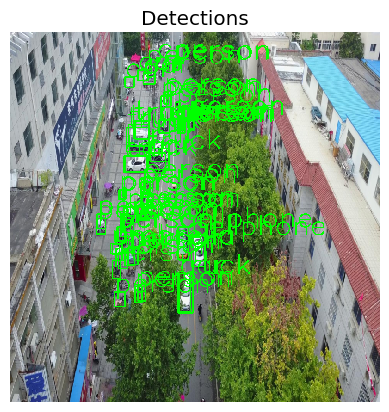

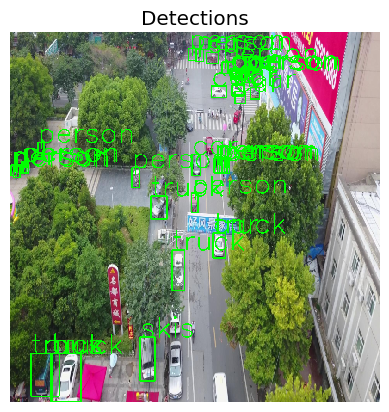

In [6]:
#use detector on data
detections = detector(sample_data)

# plot the input images with the corresponding classification output
for i in range(2): # to plot all: range(len(sample_data))):
    preds_orig = extract_predictions(detections[i], 0.5)
    img = np.asarray(sample_data.__getitem__(i)['image']).transpose(1,2,0)
    plot_image_with_boxes(img=img.copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

## 4. Loading a second, larger ResNet model

Using cache found in /Users/arjunsachar/.cache/torch/hub/facebookresearch_detr_main
/Users/arjunsachar/Documents/JATIC/hardened-extension-adversarial-robustness-toolbox/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


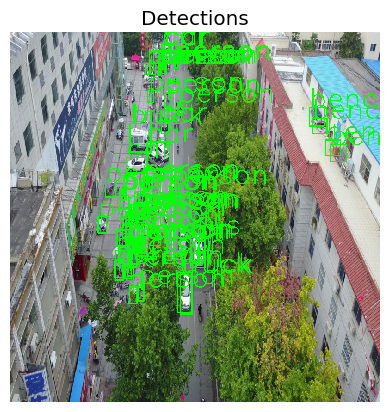

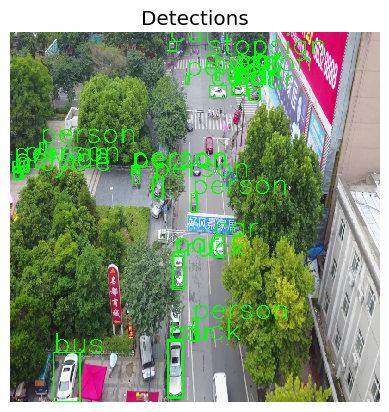

In [7]:
detector = JaticPyTorchObjectDetector(model_type="detr_resnet101",
                                      input_shape=(3, 800, 800),
                                      clip_values=(0, 1),
                                      attack_losses=( 
                                                     "loss_ce",
                                                     "loss_bbox",
                                                     "loss_giou",
                                                    ), 
                                      device_type="cpu",
                                      optimizer=torch.nn.CrossEntropyLoss(),
                                      preprocessing=preprocessing)

#use detector on data
detections = detector(sample_data)

# plot the input images with the corresponding classification output
for i in range(2): # to plot all: range(len(sample_data))):
    preds_orig = extract_predictions(detections[i], 0.5)
    img = np.asarray(sample_data.__getitem__(i)['image']).transpose(1,2,0)
    plot_image_with_boxes(img=img.copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

## 5. Load a third, FasterRCNN model

/Users/arjunsachar/Documents/JATIC/hardened-extension-adversarial-robustness-toolbox/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/arjunsachar/Documents/JATIC/hardened-extension-adversarial-robustness-toolbox/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/Users/arjunsachar/Documents/JATIC/hardened-extension-adversarial-robustness-toolbox/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Argument

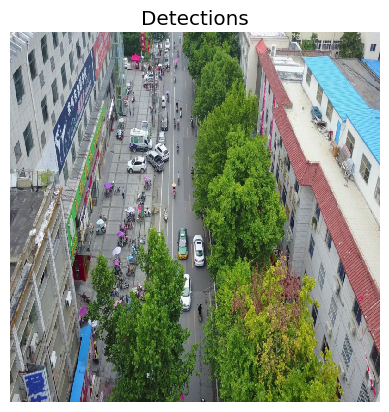

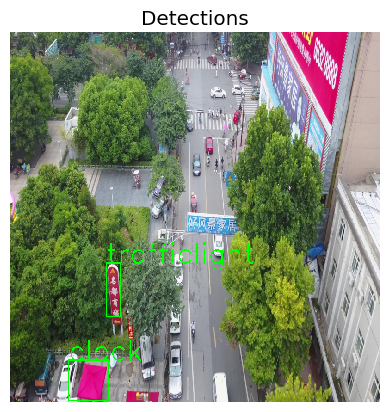

In [8]:
detector = JaticPyTorchObjectDetector(model_type="fasterrcnn_resnet50_fpn",
                                      input_shape=(3, 800, 800),
                                      clip_values=(0, 1),
                                      attack_losses=( 
                                                     "loss_ce",
                                                     "loss_bbox",
                                                     "loss_giou",
                                                    ), 
                                      device_type="cpu",
                                      optimizer=torch.nn.CrossEntropyLoss(),
                                      preprocessing=preprocessing)

#use detector on data
detections = detector(sample_data)

# plot the input images with the corresponding classification output
for i in range(2): # to plot all: range(len(sample_data))):
    preds_orig = extract_predictions(detections[i], 0.5)
    img = np.asarray(sample_data.__getitem__(i)['image']).transpose(1,2,0)
    plot_image_with_boxes(img=img.copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

This time, the model outputs only few boxes, of which not all are right. Checking [the documentation](https://pytorch.org/vision/master/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn), we observe that the model was trained on the COCO dataset, and should be fine-tuned to perform well the drone dataset.

## 6. Conclusion
We saw that with JATIC, different models can be chosen from the supported model list. However, care has to be taken that the chosen model fits the task at hand.

## 7. Next steps
- Notebook 2 on using the patch attack on object detectors
- Notebook 3 on how to defend object detectors